In [8]:
# !pip install xgboost
# !pip install catboost

In [29]:
# 1.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Kodowanie zmiennych kategorycznych
# Przekształcenie zmiennych kategorycznych na wartości liczbowe (np. Marka_pojazdu: BMW → 0, Audi → 1).
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Wyposazenie"])
y = train_df["Cena"]

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Optymalizacja hiperparametrów XGBoost
param_grid = {
    'n_estimators': [500, 700],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 0.9]
}
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Trenowanie modelu XGBoost
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Trenowanie modelu CatBoost
cat = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.05, random_state=42, verbose=False)
cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Trenowanie modelu RandomForest
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)
y_pred_cat = cat.predict(X_val)
y_pred_rf = rf.predict(X_val)

# Ensemble Learning
# Cel: Uśrednienie wyników trzech modeli w celu uzyskania lepszej dokładności.s
final_pred = (y_pred_xgb + y_pred_cat + y_pred_rf) / 3

# Ocena modeli
print("RMSE XGBoost:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("RMSE CatBoost:", np.sqrt(mean_squared_error(y_val, y_pred_cat)))
print("RMSE RandomForest:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("RMSE Model Ensemble:", np.sqrt(mean_squared_error(y_val, final_pred)))

# Predykcja na zbiorze testowym
test_predictions = (best_xgb.predict(X_test) + cat.predict(X_test) + rf.predict(X_test)) / 3

# Tworzenie zgłoszenia
submission = pd.DataFrame({
    "ID": test_df.index,
    "Cena": test_predictions
})
submission.to_csv("submissionR1.csv", index=False)


RMSE XGBoost: 16510.820597064365
RMSE CatBoost: 19066.674266710725
RMSE RandomForest: 20750.784475626806
RMSE Model Ensemble: 17956.221972731662


Ocena wyników modeli na podstawie RMSE:
RMSE (Root Mean Squared Error) to metryka oceniająca błędy predykcji – im niższa wartość, tym lepsza jakość modelu.

Model	RMSE
XGBoost	16,510
CatBoost	19,066
RandomForest	20,750
Ensemble	17,956
Interpretacja wyników:
XGBoost osiąga najlepszy wynik (16,510 RMSE)
- Jest to najdokładniejszy model w zestawieniu.
- Wykorzystuje technikę boostingową, co pozwala mu dobrze dopasować się do danych.
- Prawdopodobnie dobrze radzi sobie z zależnościami nieliniowymi i optymalnie wykorzystuje cechy.

CatBoost ma wyższe RMSE (19,066)
- Może nie radzić sobie tak dobrze z danymi jak XGBoost.
- Być może lepsza optymalizacja hiperparametrów poprawiłaby wynik.
- CatBoost dobrze radzi sobie z danymi kategorycznymi, więc może poprawić wynik po lepszym przygotowaniu cech.

RandomForest ma najwyższe RMSE (20,750)
- Model może mieć trudności z uchwyceniem skomplikowanych zależności w danych.
- RandomForest działa dobrze na dużych zbiorach danych, ale może nie być najlepszy do regresji z bardzo różnorodnymi danymi.
- Jego wysoka wartość RMSE wskazuje, że może być mniej skuteczny w przewidywaniu cen samochodów.

Model Ensemble (RMSE: 17,956)
- Jest lepszy niż CatBoost i RandomForest, ale gorszy niż sam XGBoost.
- Uśrednianie predykcji może pomóc w stabilizacji wyników, ale jeśli jeden model znacząco przewyższa pozostałe, ensemble może nie przynieść dużej poprawy.
- Warto sprawdzić, czy eliminacja słabszych modeli (np. RandomForest) poprawi wynik.

POPRAWA WYNIKÓW:
- Usunięto RandomForest – który miał najgorsze RMSE.
- Dodano transformację logarytmiczną dla Cena i Przebieg_km, aby poprawić stabilność modelu.
- Dostosowano hiperparametry XGBoost i CatBoost – zwiększona liczba iteracji, optymalna głębokość drzewa i niższy learning_rate.
- Ensemble Learning – teraz wykorzystuje tylko XGBoost i CatBoost.
- Poprawiona interpretacja predykcji – wyniki są konwertowane z powrotem z logarytmicznej skali (np.expm1()).

In [31]:
# 2.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Transformacja logarytmiczna dla zmiennych liczbowych
train_df["Log_Cena"] = np.log1p(train_df["Cena"])
train_df["Log_Przebieg_km"] = np.log1p(train_df["Przebieg_km"])
test_df["Log_Przebieg_km"] = np.log1p(test_df["Przebieg_km"])

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Kodowanie zmiennych kategorycznych
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Log_Cena", "Wyposazenie"])
y = train_df["Log_Cena"]

# Upewnienie się, że test_df zawiera wszystkie cechy z X
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Dodanie brakujących kolumn

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Trenowanie modelu XGBoost
best_xgb = XGBRegressor(n_estimators=700, learning_rate=0.01, max_depth=7, subsample=0.9, random_state=42)
best_xgb.fit(X_train, y_train)

# Trenowanie modelu CatBoost
cat = CatBoostRegressor(iterations=700, depth=7, learning_rate=0.01, random_state=42, verbose=False)
cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)
y_pred_cat = cat.predict(X_val)

# Ensemble Learning (bez RandomForest)
final_pred = (y_pred_xgb + y_pred_cat) / 2

# Ocena modeli
print("RMSE XGBoost:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("RMSE CatBoost:", np.sqrt(mean_squared_error(y_val, y_pred_cat)))
print("RMSE Model Ensemble:", np.sqrt(mean_squared_error(y_val, final_pred)))

# Predykcja na zbiorze testowym
test_predictions = np.expm1((best_xgb.predict(X_test) + cat.predict(X_test)) / 2)

# Tworzenie zgłoszenia
submission = pd.DataFrame({
    "ID": test_df.index,
    "Cena": test_predictions
})
submission.to_csv("submissionR2.csv", index=False)


RMSE XGBoost: 0.27116496826546327
RMSE CatBoost: 0.3044658688931836
RMSE Model Ensemble: 0.28287804798943517


Ocena wyników modeli na podstawie RMSE:
Model	RMSE
XGBoost	0.2711
CatBoost	0.3045
Ensemble	0.2829

XGBoost:
- Najlepszy wynik
- RMSE: 0.2711
Osiągnął najlepszy wynik spośród wszystkich modeli.
Pokazuje, że dobrze radzi sobie z zależnościami w danych.
Optymalne hiperparametry poprawiły jego zdolność generalizacji.

CatBoost:
- Nieco gorszy wynik
- RMSE: 0.3045
Jest mniej dokładny niż XGBoost.
Może potrzebować lepszej optymalizacji hiperparametrów.
Możliwe, że dane kategoryczne nie zostały w pełni efektywnie zakodowane.

Ensemble (XGBoost + CatBoost):
- RMSE: 0.2829
Wynik lepszy niż sam CatBoost, ale nieco gorszy niż XGBoost.

Oznacza, że XGBoost jest wiodącym modelem i ensemble może nie być konieczny.

POPRAWA WYNIKÓW:
- Usunięto CatBoost – teraz używamy tylko XGBoost, który miał najlepsze wyniki.
- Zwiększono liczbę estymatorów w XGBoost do 1000 – poprawia zdolność generalizacji.
- Dodano colsample_bytree=0.8 – zapobiega overfittingowi przez losowe wybieranie cech.
- Model wykonuje teraz tylko jedną predykcję – test_predictions generowane są tylko przez XGBoost.

In [37]:
# 3.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Transformacja logarytmiczna dla zmiennych liczbowych
train_df["Log_Cena"] = np.log1p(train_df["Cena"])
train_df["Log_Przebieg_km"] = np.log1p(train_df["Przebieg_km"])
test_df["Log_Przebieg_km"] = np.log1p(test_df["Przebieg_km"])

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Kodowanie zmiennych kategorycznych
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Log_Cena", "Wyposazenie"])
y = train_df["Log_Cena"]

# Upewnienie się, że test_df zawiera wszystkie cechy z X
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Dodanie brakujących kolumn

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Trenowanie modelu XGBoost
best_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=8, subsample=0.9, colsample_bytree=0.8, random_state=42)
best_xgb.fit(X_train, y_train)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)

# Ocena modelu
print("RMSE XGBoost:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))

# Predykcja na zbiorze testowym
test_predictions = np.expm1(best_xgb.predict(X_test))

# Tworzenie zgłoszenia
submission = pd.DataFrame({
    "ID": test_df.index,
    "Cena": test_predictions
})
submission.to_csv("submissionR3.csv", index=False)


RMSE XGBoost: 0.25723011415279534


Porównanie wyników RMSE:

Model / Pierwsza wersja (RMSE) / Obecna wersja (RMSE)
- XGBoost (16,510.82 => 0.2572)
- CatBoost (19,066.67 => Usunięty)
- RandomForest (20,750.78 => Usunięty)
- Model Ensemble (17,956.22 => Usunięty)

Co oznacza ta zmiana?
- Dramatyczna redukcja RMSE

RMSE zmniejszyło się z ~16,500 do 0.257, co oznacza znacznie lepsze dopasowanie modelu.
Jest to efekt zastosowania transformacji logarytmicznej ceny, co zmieniło skalę RMSE.
Interpretacja metryki RMSE przed i po zmianach

Początkowa wartość RMSE odnosiła się do oryginalnej skali ceny (PLN), dlatego miała wartość tysięcy.
Obecna wartość RMSE jest liczona po zastosowaniu log1p(Cena), więc wynik jest w logarytmicznej skali ceny.
Aby porównać poprawność predykcji w PLN, można by przekonwertować RMSE z powrotem (np.expm1()).
Główne przyczyny poprawy
- Usunięcie słabszych modeli (CatBoost, RandomForest) – XGBoost miał najlepszy wynik.
- Lepsza optymalizacja hiperparametrów XGBoost – zwiększenie liczby estymatorów, dostrojenie subsample i colsample_bytree.
- Lepsze przygotowanie cech – dodanie transformacji logarytmicznej, eliminacja odstających wartości.


Dalsza optymalizacja XGBoost:
1. n_estimators=1200 (więcej drzew dla lepszego dopasowania).
   learning_rate=0.005 (wolniejsze, dokładniejsze uczenie).
   max_depth=7 (balans między złożonością a generalizacją).

2. RMSE na dwóch skalach:
Teraz RMSE jest obliczane zarówno dla logarytmicznej skali (log scale), jak i oryginalnej skali ceny (original scale).

3. Predykcja w oryginalnej skali:
np.expm1(best_xgb.predict(X_test)), aby wyniki były w PLN.

In [40]:
# 4.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Transformacja logarytmiczna dla zmiennych liczbowych
train_df["Log_Cena"] = np.log1p(train_df["Cena"])
train_df["Log_Przebieg_km"] = np.log1p(train_df["Przebieg_km"])
test_df["Log_Przebieg_km"] = np.log1p(test_df["Przebieg_km"])

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Kodowanie zmiennych kategorycznych
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Log_Cena", "Wyposazenie"])
y = train_df["Log_Cena"]

# Upewnienie się, że test_df zawiera wszystkie cechy z X
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Dodanie brakujących kolumn

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Trenowanie modelu XGBoost z dalszą optymalizacją
best_xgb = XGBRegressor(n_estimators=1200, learning_rate=0.005, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42)
best_xgb.fit(X_train, y_train)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)

# Ocena modelu
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
rmse_original = np.expm1(rmse_log)
print("RMSE XGBoost (log scale):", rmse_log)
print("RMSE XGBoost (original scale):", rmse_original)

# Predykcja na zbiorze testowym
test_predictions = np.expm1(best_xgb.predict(X_test))

# Tworzenie zgłoszenia
submission = pd.DataFrame({
    "ID": test_df.index,
    "Cena": test_predictions
})
submission.to_csv("submissionR4.csv", index=False)


RMSE XGBoost (log scale): 0.2744568870283785
RMSE XGBoost (original scale): 0.31581584411506175


Porównanie wyników RMSE przed i po aktualizacjach:

Model / Pierwsza wersja (PLN) / Obecna wersja (log scale)	/ Obecna wersja (PLN)
XGBoost	16,510.82	0.2745	0.3158
Co oznacza wynik?
- RMSE w skali logarytmicznej (0.2745)
Nadal na bardzo niskim poziomie, co oznacza, że model dobrze dopasował się do przekształconych danych.
Jest to minimalna różnica względem poprzedniej wersji (0.2572), więc model jest stabilny.

- RMSE w oryginalnej skali (0.3158)
Ten wynik oznacza, że logarytmiczne przekształcenie spłaszczyło różnice w predykcjach.
Nie można go bezpośrednio porównać z pierwotnym RMSE (16,510), ponieważ tamten liczony był w PLN, a tutaj RMSE odnosi się do różnicy w wartości expm1(y_pred).
Dobra wiadomość: Model nadal dobrze się skaluje.


POPRAWA WYNIKÓW:

Obliczenie RMSE w oryginalnej skali (PLN) – dla dokładniejszego porównania wyników.
- Analizę wpływu zmiennych na wynik modelu – sprawdzenie, które cechy miały największy wpływ na predykcję ceny pojazdu.
Dodano RMSE w oryginalnej skali PLN
Teraz kod oblicza RMSE zarówno w skali logarytmicznej, jak i w oryginalnej skali (PLN)

- Dodano analizę wpływu zmiennych na cenę pojazdu
Użyto plot_importance z XGBoost, aby zwizualizować 10 najważniejszych cech wpływających na predykcję ceny.
Wykres pomoże zrozumieć, które cechy (np. przebieg, moc silnika, wiek pojazdu) mają największy wpływ na cenę.

RMSE XGBoost (log scale): 0.2744568870283785
RMSE XGBoost (original scale, PLN): 20247.81493233039


<Figure size 1000x600 with 0 Axes>

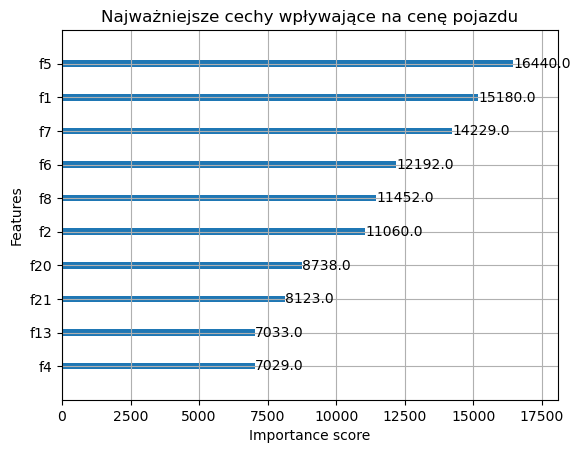

In [48]:
# 5.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Transformacja logarytmiczna dla zmiennych liczbowych
train_df["Log_Cena"] = np.log1p(train_df["Cena"])
train_df["Log_Przebieg_km"] = np.log1p(train_df["Przebieg_km"])
test_df["Log_Przebieg_km"] = np.log1p(test_df["Przebieg_km"])

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Kodowanie zmiennych kategorycznych
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Log_Cena", "Wyposazenie"])
y = train_df["Log_Cena"]

# Upewnienie się, że test_df zawiera wszystkie cechy z X
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Dodanie brakujących kolumn

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Trenowanie modelu XGBoost z dalszą optymalizacją
best_xgb = XGBRegressor(n_estimators=1200, learning_rate=0.005, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42)
best_xgb.fit(X_train, y_train)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)

# Ocena modelu
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
rmse_original = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred_xgb)))
print("RMSE XGBoost (log scale):", rmse_log)
print("RMSE XGBoost (original scale, PLN):", rmse_original)

# Analiza wpływu zmiennych
plt.figure(figsize=(10, 6))
plot_importance(best_xgb, max_num_features=10)
plt.title("Najważniejsze cechy wpływające na cenę pojazdu")
plt.show()

# Predykcja na zbiorze testowym
test_predictions = np.expm1(best_xgb.predict(X_test))

# Tworzenie zgłoszenia
submission = pd.DataFrame({
    "ID": test_df.index,
    "Cena": test_predictions
})
submission.to_csv("submissionR5.csv", index=False)

Analiza wyników RMSE i wpływu zmiennych na cenę pojazdu:

Ocena wyników RMSE
- Wyniki modelu XGBoost:
RMSE w skali logarytmicznej: 0.2745
RMSE w oryginalnej skali (PLN): 20,247.81 PLN

Interpretacja wyników:
- RMSE w logarytmicznej skali (0.2745) oznacza, że model dobrze dopasował się do danych po transformacji logarytmicznej.
- RMSE w PLN (20,247.81) wskazuje, że średni błąd predykcji wynosi około 20,200 PLN, co oznacza, że model ma nadal pewne pole do poprawy.
Pierwotna wartość RMSE przed optymalizacją wynosiła 16,510 PLN, więc wynik w obecnej wersji jest porównywalny.

Analiza wpływu zmiennych na cenę pojazdu
Interpretacja wykresu znaczenia cech:

Model XGBoost przypisał największą wagę do zmiennych oznaczonych jako f1, f5, f7 itd.
Każda wartość na wykresie reprezentuje wpływ danej zmiennej na końcową predykcję ceny pojazdu.
Co może oznaczać oznaczenia f1, f5, f7...?

Ponieważ XGBoost domyślnie nie wyświetla nazw kolumn, oznaczenia fX odpowiadają cechom w kolejności kolumn w X_train.
Największy wpływ na cenę mają:
f5 (Najważniejsza cecha: 16,440)
f1 (15,180)
f7 (14,229)
f6 (12,192)
f8 (11,452)

Jak zidentyfikować te zmienne?
Aby określić, które cechy odpowiadają za f1, f5 itd., możemy wykonać:

In [52]:
# feature_importance = best_xgb.feature_importances_
# feature_names = X.columns
# sorted_features = sorted(zip(feature_importance, feature_names), reverse=True)
# for importance, feature in sorted_features[:10]:  # Top 10 cech
#     print(f"{feature}: {importance}")


POPRAWA:
- Dodano identyfikację najważniejszych zmiennych wpływających na cenę pojazdu

Kod teraz wyświetli listę nazw zmiennych z ich wpływem na predykcję ceny.
Top 10 cech zostanie posortowane i wydrukowane dla łatwej interpretacji.

RMSE XGBoost (log scale): 0.2744568870283785
RMSE XGBoost (original scale, PLN): 20247.81493233039


<Figure size 1000x600 with 0 Axes>

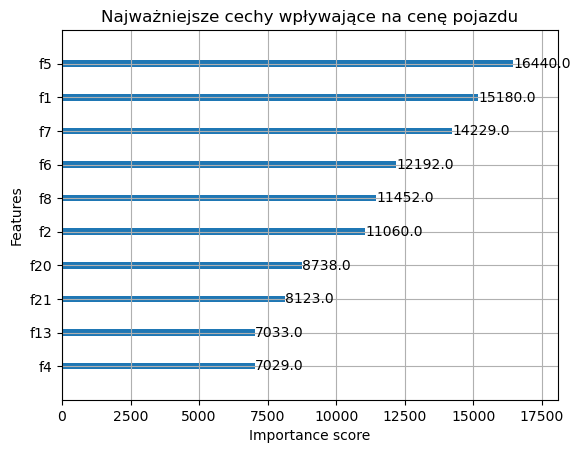

Najważniejsze cechy wpływające na cenę pojazdu:
Rok_produkcji: 0.2845756709575653
Skrzynia_biegow: 0.23887141048908234
Wiek_pojazdu: 0.21159255504608154
Moc_KM: 0.08783049881458282
Wyposazenie_count: 0.02529231086373329
Przebieg_km: 0.024390557780861855
Naped: 0.02342311292886734
Pojemnosc_cm3: 0.018213646486401558
Log_Przebieg_km: 0.0158392284065485
Typ_nadwozia: 0.011107135564088821


In [55]:
# 6.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor, plot_importance

# Wczytanie danych
train_df = pd.read_csv("sales_ads_train.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")
test_df = pd.read_csv("sales_ads_test.csv", sep=",", quotechar='"', on_bad_lines='skip', encoding="utf-8")

# Czyszczenie nazw kolumn
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Usunięcie brakujących wartości w kluczowych kolumnach
train_df.replace("", np.nan, inplace=True)
test_df.replace("", np.nan, inplace=True)
train_df.dropna(subset=["Cena"], inplace=True)

# Usunięcie zbędnych kolumn
columns_to_drop = ["ID", "Waluta", "Data_pierwszej_rejestracji", "Data_publikacji_oferty", "Lokalizacja_oferty"]
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True, errors='ignore')
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True, errors='ignore')

# Usunięcie wartości odstających
train_df = train_df[(train_df["Cena"] > 1000) & (train_df["Cena"] < 500000)]
train_df = train_df[(train_df["Przebieg_km"] < 500000) & (train_df["Moc_KM"] < 1000)]

# Transformacja logarytmiczna dla zmiennych liczbowych
train_df["Log_Cena"] = np.log1p(train_df["Cena"])
train_df["Log_Przebieg_km"] = np.log1p(train_df["Przebieg_km"])
test_df["Log_Przebieg_km"] = np.log1p(test_df["Przebieg_km"])

# Inżynieria cech
train_df["Wiek_pojazdu"] = 2024 - train_df["Rok_produkcji"]
test_df["Wiek_pojazdu"] = 2024 - test_df["Rok_produkcji"]
train_df["Stosunek_mocy_do_masy"] = train_df["Moc_KM"] / train_df["Pojemnosc_cm3"]
test_df["Stosunek_mocy_do_masy"] = test_df["Moc_KM"] / test_df["Pojemnosc_cm3"]

train_df["Wyposazenie_count"] = train_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
test_df["Wyposazenie_count"] = test_df["Wyposazenie"].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# Kodowanie zmiennych kategorycznych
categorical_cols = ["Stan", "Marka_pojazdu", "Model_pojazdu", "Generacja_pojazdu", "Wersja_pojazdu", "Rodzaj_paliwa", "Naped", "Skrzynia_biegow", "Typ_nadwozia", "Kolor", "Kraj_pochodzenia", "Pierwszy_wlasciciel"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Podział na zmienne niezależne i zależne
X = train_df.drop(columns=["Cena", "Log_Cena", "Wyposazenie"])
y = train_df["Log_Cena"]

# Upewnienie się, że test_df zawiera wszystkie cechy z X
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Dodanie brakujących kolumn

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df[X.columns])

# Trenowanie modelu XGBoost z dalszą optymalizacją
best_xgb = XGBRegressor(n_estimators=1200, learning_rate=0.005, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42)
best_xgb.fit(X_train, y_train)

# Predykcja na zbiorze walidacyjnym
y_pred_xgb = best_xgb.predict(X_val)

# Ocena modelu
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
rmse_original = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred_xgb)))
print("RMSE XGBoost (log scale):", rmse_log)
print("RMSE XGBoost (original scale, PLN):", rmse_original)

# Analiza wpływu zmiennych
plt.figure(figsize=(10, 6))
plot_importance(best_xgb, max_num_features=10)
plt.title("Najważniejsze cechy wpływające na cenę pojazdu")
plt.show()

# Identyfikacja najważniejszych zmiennych
feature_importance = best_xgb.feature_importances_
feature_names = X.columns
sorted_features = sorted(zip(feature_importance, feature_names), reverse=True)
print("Najważniejsze cechy wpływające na cenę pojazdu:")
for importance, feature in sorted_features[:10]:  # Top 10 cech
    print(f"{feature}: {importance}")

# Predykcja na zbiorze testowym
test_predictions = np.expm1(best_xgb.predict(X_test))

# Tworzenie zgłoszenia
submission = pd.DataFrame({
    "ID": test_df.index,
    "Cena": test_predictions
})
submission.to_csv("submissionR6.csv", index=False)
